# New York Airbnb Open Data

To prepare for technical interviews, I explored in 90 minutes this dataset taken from Kaggle (https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data).

## Data retrieval

In [1]:
# import useful packages
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
import statsmodels.api as sm
import re
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
import datetime
import statsmodels.api as sm

In [2]:
# load data as a DataFrame
df = pd.read_csv('../data/AB_NYC_2019.csv')

In [97]:
# check number of observations and potential features
df.shape # 49k observations and 16 variables

(48895, 16)

In [98]:
# check 5 first observations
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [99]:
# check datatypes and number of empty values per row 
df.info() # some columns have Null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

## Data exploration and preparation

In [6]:
# perform exploratory data analysis 
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [100]:
# check for duplicates
print(df.duplicated().sum())
# drop duplicates
df.drop_duplicates(inplace=True)

0


In [101]:
# show missing values by column
df.isnull().sum().sort_values(ascending=False)/len(df) #NaN percentage for each column

last_review                       0.205583
reviews_per_month                 0.205583
host_name                         0.000429
name                              0.000327
id                                0.000000
host_id                           0.000000
neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [102]:
# transform last_review to date
df.last_review = pd.to_datetime(df.last_review, format='%Y-%m-%d')

In [104]:
# replace missing values
# mean, median, most_frequent, constant (use fill_value)
simpleimputer = SimpleImputer(strategy='mean')
df['reviews_per_month'] = simpleimputer.fit_transform(df[['reviews_per_month']])

In [105]:
# drop useless variables
drop_var = ['id', 'name','host_id', 'host_name', 'last_review']
df.drop(columns=drop_var, inplace=True)

In [106]:
# convert all the categorical variables into dummy variables
df_cat = df[['neighbourhood_group', 'neighbourhood','room_type']]
df_dummies = pd.get_dummies(df_cat)

In [107]:
# concatenate both df
df_preprocessed = pd.concat([df.drop(columns=df_cat), df_dummies], axis=1)

<AxesSubplot:xlabel='price', ylabel='Density'>

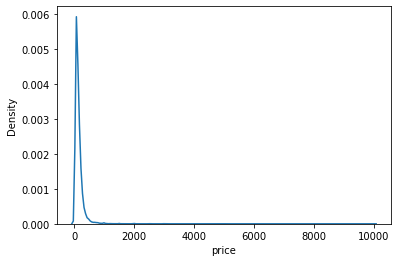

In [109]:
# plot distribution of price
sns.kdeplot(df.price) # we can see that there are some outliers

In [110]:
# one airbnb has a price of 9151 dollars
df.price.argmax()

9151

In [111]:
# robust scale the price
minmaxscaler = MinMaxScaler()
df_preprocessed['price'] = minmaxscaler.fit_transform(df_preprocessed[['price']])
df['price'] = minmaxscaler.fit_transform(df[['price']])

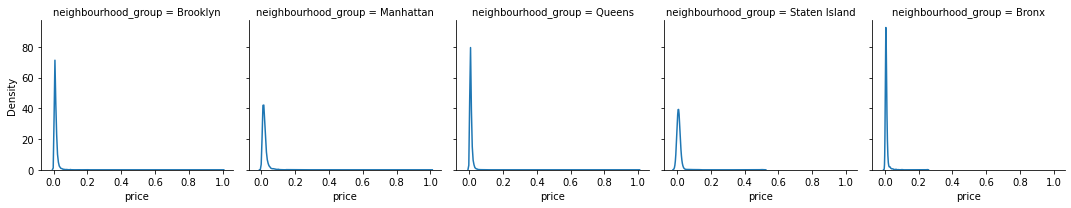

In [112]:
# plot facet grid to see how neighbourhood group affects the price
g = sns.FacetGrid(data=df, col='neighbourhood_group')
g.map(sns.kdeplot, 'price')

/Users/raphaelvoortman/.pyenv/versions/3.8.6/envs/lewagon_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


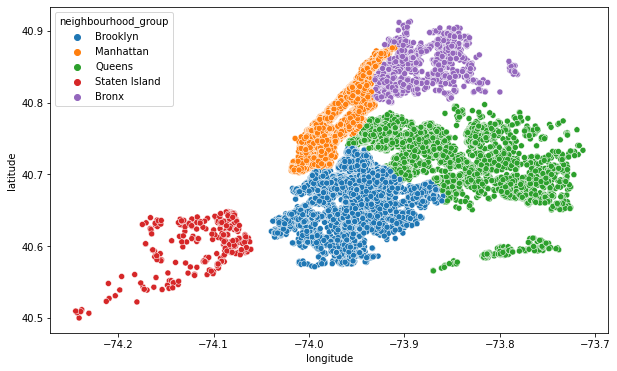

In [139]:
# plot location of airbnb's
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude,df.latitude,hue=df.neighbourhood_group)
plt.ioff()

/Users/raphaelvoortman/.pyenv/versions/3.8.6/envs/lewagon_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


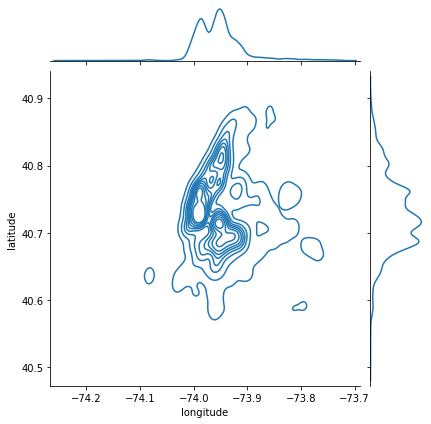

In [181]:
sns.jointplot(df.longitude,df.latitude, kind='kde', data=df)

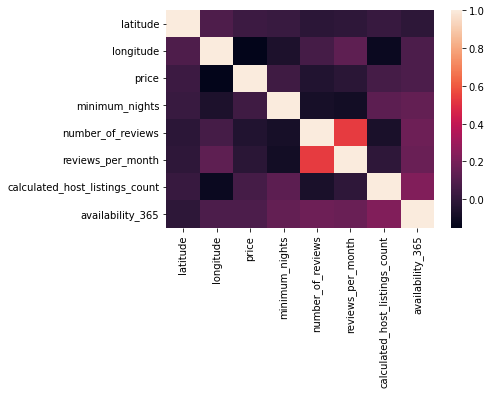

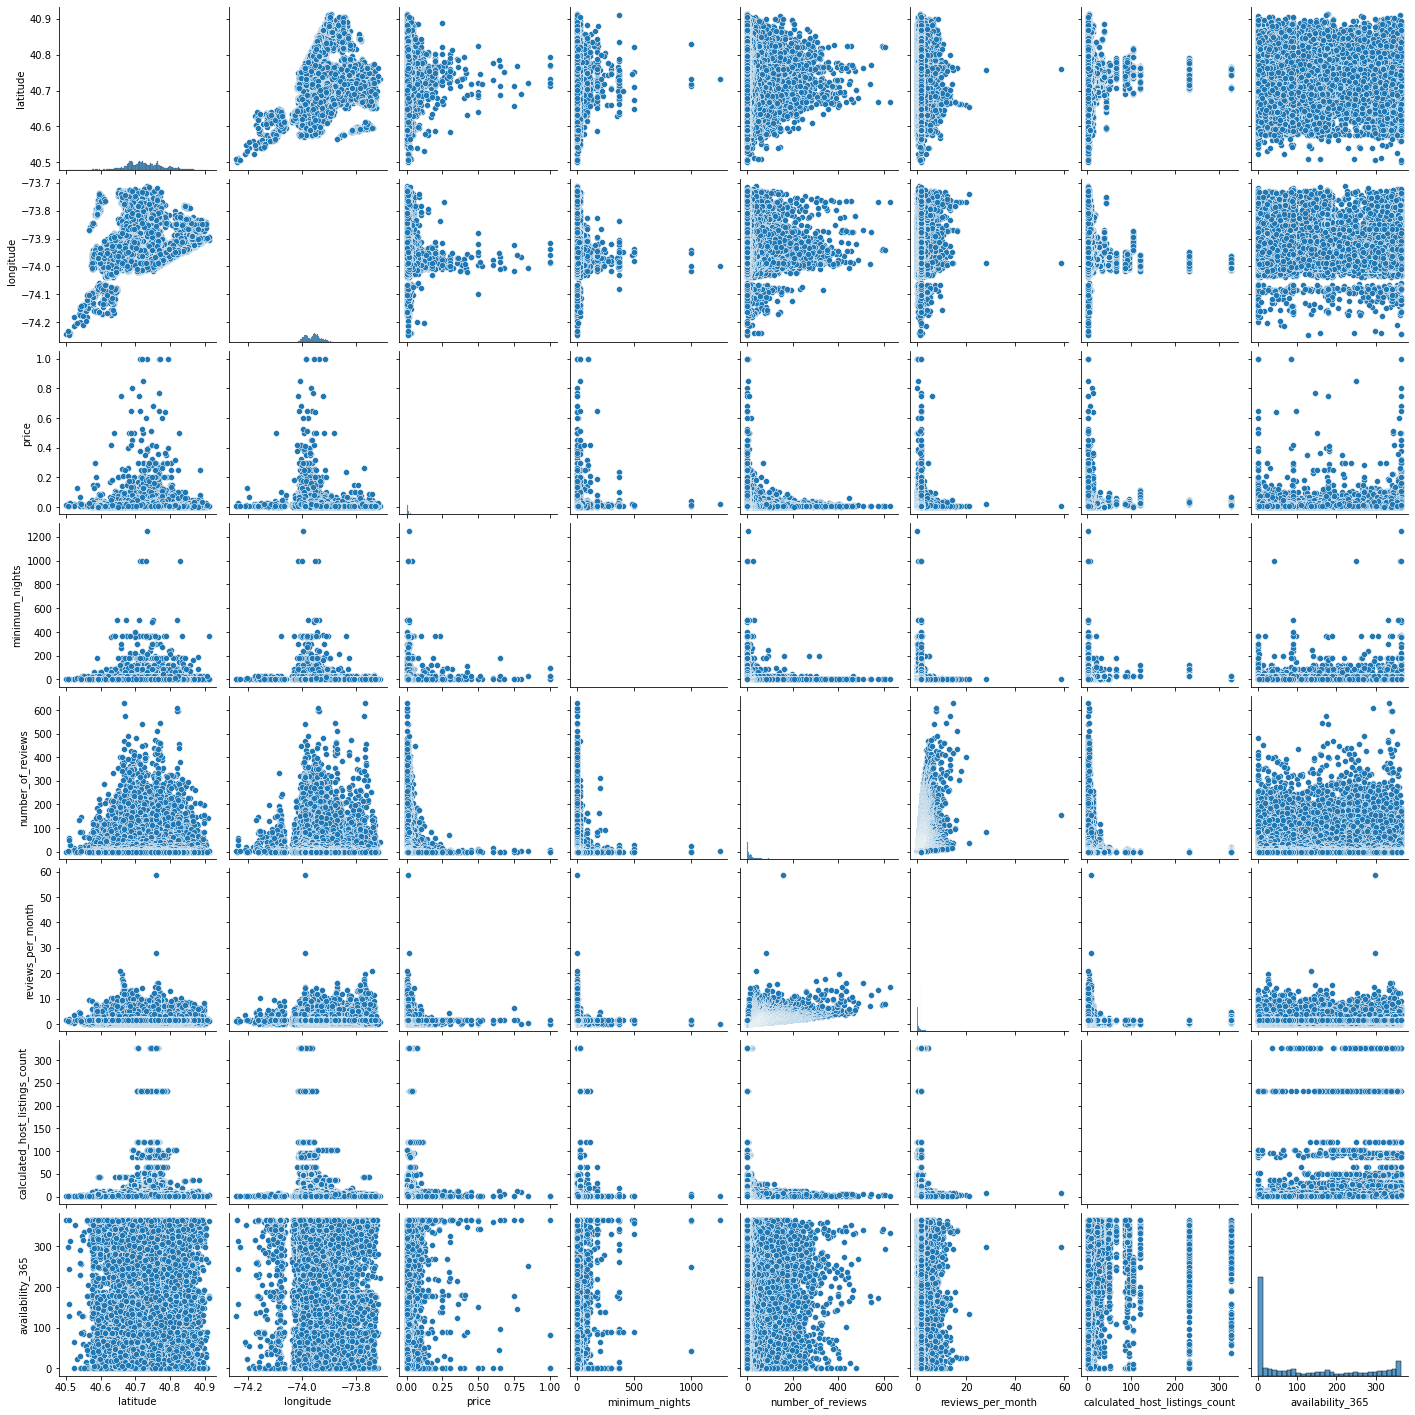

In [184]:
sns.heatmap(df.corr())
sns.pairplot(data=df)

/Users/raphaelvoortman/.pyenv/versions/3.8.6/envs/lewagon_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


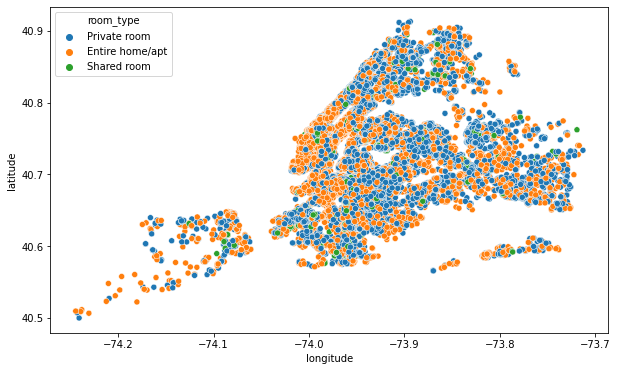

In [162]:
# plot location of airbnb's
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude,df.latitude,hue=df.room_type)
plt.ioff()

<AxesSubplot:xlabel='room_type', ylabel='price'>

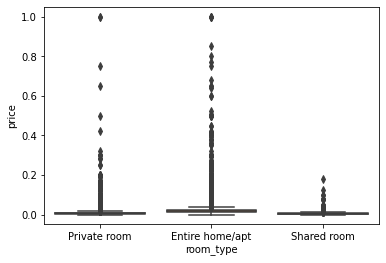

In [114]:
# shared room's prices are cheap whereas there is all kind of price ranges for private rooms and entire homes
sns.boxplot(x=df.room_type, y=df.price)

/Users/raphaelvoortman/.pyenv/versions/3.8.6/envs/lewagon_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='number_of_reviews'>

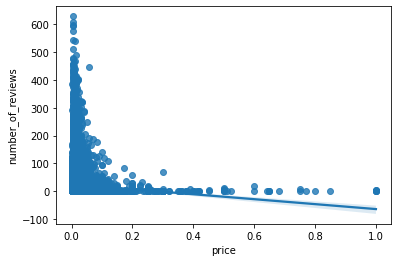

In [115]:
# scatterplot of price and number_of_reviews
sns.regplot(df.price, df.number_of_reviews)

/Users/raphaelvoortman/.pyenv/versions/3.8.6/envs/lewagon_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='reviews_per_month'>

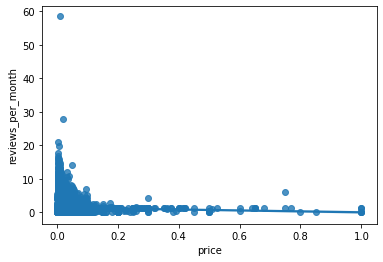

In [116]:
# scatter plot for price and reviews_per_month
sns.regplot(df.price, df.reviews_per_month)

/Users/raphaelvoortman/.pyenv/versions/3.8.6/envs/lewagon_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='calculated_host_listings_count'>

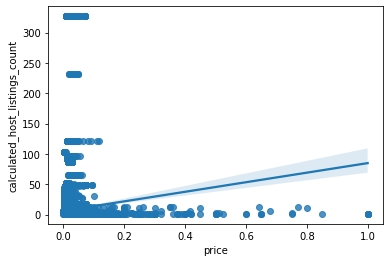

In [52]:
# scatter plot for price and calculated host listings count
sns.regplot(df.price, df.calculated_host_listings_count)

/Users/raphaelvoortman/.pyenv/versions/3.8.6/envs/lewagon_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='availability_365'>

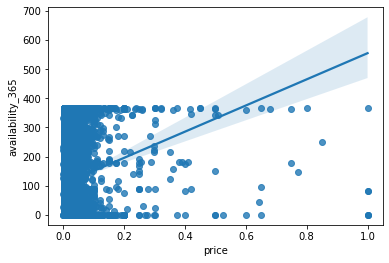

In [117]:
# scatter plot for price and availability
sns.regplot(df.price, df.availability_365)

/Users/raphaelvoortman/.pyenv/versions/3.8.6/envs/lewagon_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='minimum_nights'>

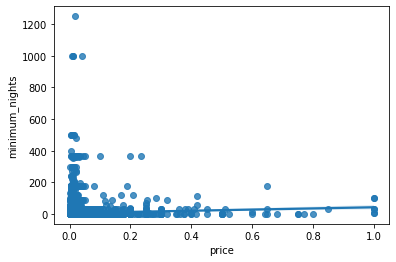

In [118]:
# scatter plot for price and availability
sns.regplot(df.price, df.minimum_nights)

/Users/raphaelvoortman/.pyenv/versions/3.8.6/envs/lewagon_tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Neighbourhood Group')

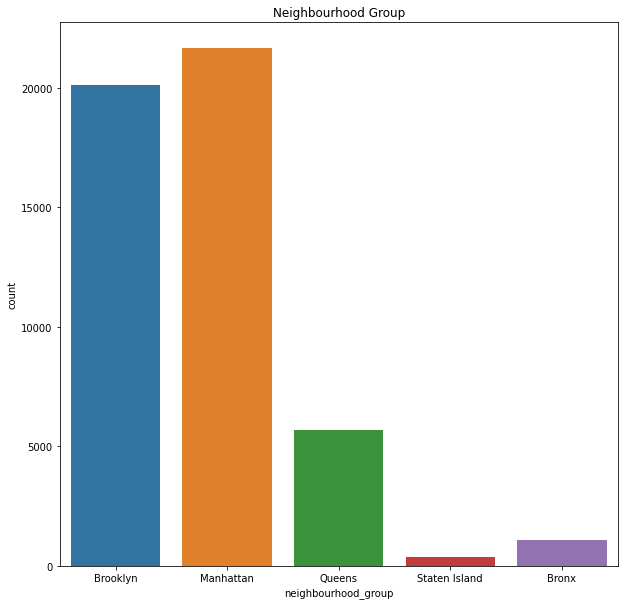

In [138]:
# plot number of airbnb per neighbourhood group
sns.countplot(df['neighbourhood_group'])
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Neighbourhood Group')

In [119]:
# check correlations between variables
corr_df = df.corr().unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
44,reviews_per_month,number_of_reviews,0.530093
37,number_of_reviews,reviews_per_month,0.530093
62,availability_365,calculated_host_listings_count,0.225701
55,calculated_host_listings_count,availability_365,0.225701
60,availability_365,number_of_reviews,0.172028


In [169]:
# check variables that are the most positivily correlated with the target
df_preprocessed.corr()[['price']].sort_values(by='price', ascending=False)

,price
price,1.000000
room_type_Entire home/apt,0.255857
neighbourhood_group_Manhattan,0.163976
neighbourhood_Midtown,0.097781
neighbourhood_Tribeca,0.084814
...,...
neighbourhood_Bushwick,-0.065166
neighbourhood_group_Queens,-0.080205
neighbourhood_group_Brooklyn,-0.098603
longitude,-0.150019


In [170]:
# check variables that are the most negatively correlated with the target
df_preprocessed.corr()[['price']].sort_values(by='price', ascending=True)

,price
room_type_Private room,-0.240246
longitude,-0.150019
neighbourhood_group_Brooklyn,-0.098603
neighbourhood_group_Queens,-0.080205
neighbourhood_Bushwick,-0.065166
...,...
neighbourhood_Tribeca,0.084814
neighbourhood_Midtown,0.097781
neighbourhood_group_Manhattan,0.163976
room_type_Entire home/apt,0.255857


In [122]:
# define X and y
X = df_preprocessed.drop(columns=['price'])
y = df_preprocessed['price']

In [123]:
# splitting train and test set (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Model

In [163]:
# try with OLS regression
model = sm.OLS(y_train, X_train)
res = model.fit()
print(res.summary()) # a lot of features are non significant / R-squared is low

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     326.4
Date:                Tue, 28 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:37:01   Log-Likelihood:                 80057.
No. Observations:               34226   AIC:                        -1.601e+05
Df Residuals:                   34215   BIC:                        -1.600e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
number

In [164]:
# trying with less features
X = df_preprocessed[[
                     'number_of_reviews',
                     'reviews_per_month',
                     'calculated_host_listings_count',
                     'availability_365',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'room_type_Entire home/apt',
                     'room_type_Private room',
                     'room_type_Shared room'
                    ]]
y = df_preprocessed['price']

In [157]:
# splitting train and test set (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [158]:
# try with linear regression model from sklearn
model_2 = LinearRegression()
results = cross_validate(model_2, X_train, y_train, cv=5)
np.mean(results['test_score']) # r2 is poor

0.09381778776367326

In [159]:
# try with decision tree 
model_3 = DecisionTreeRegressor(min_samples_leaf=.01)
model_3.fit(X_train,y_train)

DecisionTreeRegressor(min_samples_leaf=0.01)

## Model Evaluation and Tuning

In [160]:
# get score on test set
y_pred = model_3.predict(X_test)
r2_score(y_test,y_pred) # r2 on test set is poor too

0.13065944351460657

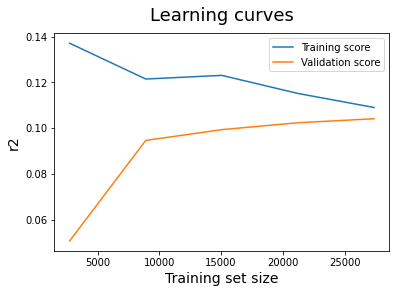

In [161]:
# plot learning curves
train_sizes, train_scores, validation_scores = learning_curve(estimator = model_3,
                                                              X = X_train,
                                                              y = y_train,
                                                              cv = 5,
                                                              n_jobs=-1,
                                                              scoring='r2')
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation score')
plt.ylabel('r2', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

In [178]:
# trying a forth model (knn)
model_4 = KNeighborsRegressor(n_neighbors=50)
results = cross_validate(model_4, X_train, y_train, cv=5)
np.mean(results['test_score']) # r2 is poor

0.04183502065686362

## Conclusion

* In this notebook I explored the New York Airbnb Open datset to understand what affects airbnb prices in New York and to see if the price can be predicted. 
* Even though I could notice the price is correlated with some features, the features do not provide enough information to create an accurate prediction model for the price. Indeed, the best R-squared I achieved was 13% which is poor. 
* Ideally, more features should be fetched to characterise the bookings (ex. average rating, WiFi availability, smoker versus non-smoker) to differentiate more. 
* Furthermore, more complex models should be tried with hyperparameter optimization.